In [3]:
import scipy as sp
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import cellrank as cr
import seaborn as sb
import statot
import pegasus as pg

In [4]:
dir="../../data/mESC/"
t = pd.read_csv(dir + "time.txt", sep = "\t", index_col = 0, header = None)
genes = pd.read_csv(dir + "tf.txt", sep = "\t", index_col = 0, header = None)
df = pd.read_csv(dir + "exp.txt", sep = "\t", header = None, dtype = np.float64).T
df.set_index(t.index, inplace = True)

In [5]:
adata = ad.AnnData(df)
adata.obs['t'] = np.array(t.iloc[:, 0])
adata.var.set_index(genes.index, inplace = True)
# adata.obs.columns = pd.Index(["pseudotime", "day"])
sc.pp.highly_variable_genes(adata, n_top_genes = 25)

/data/gpfs/projects/punim0638/stephenz/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/gpfs/projects/punim0638/stephenz/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/gpfs/projects/punim0638/stephenz/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, 25)
sc.tl.umap(adata)
sc.tl.tsne(adata)

In [7]:
k = cr.tl.kernels.PseudotimeKernel(adata, time_key = "t").compute_transition_matrix() + 0.25*cr.tl.kernels.ConnectivityKernel(adata).compute_transition_matrix()
adata.obsm["P_dpt"] = k.transition_matrix.todense()
x_ord = np.argsort(adata.obs.t)

  0%|          | 0/456 [00:00<?, ?cell/s]

In [8]:
# construct cost matrix along discrete manifold 
G_sp = adata.uns['neighbors']['distances']
adata.obsm["C"] = sp.sparse.csgraph.floyd_warshall(G_sp, directed = False)**2
# Stationary OT
sink_idx = (adata.obs.t >= np.quantile(adata.obs.t, 0.9)) & (adata.obs.t < np.quantile(adata.obs.t, 1.0))
R = np.zeros(adata.shape[0])
R[sink_idx] = -50/sum(sink_idx)
R[~sink_idx] = -R.sum()/sum(~sink_idx)
gamma, mu, nu = statot.inference.statot(adata.obsm["X_pca"], g = np.exp(R), dt = 1, C = adata.obsm["C"], eps = 1.0*adata.obsm["C"].mean(), method = "quad")
adata.obsm["P_statot"] = statot.inference.row_normalise(gamma)

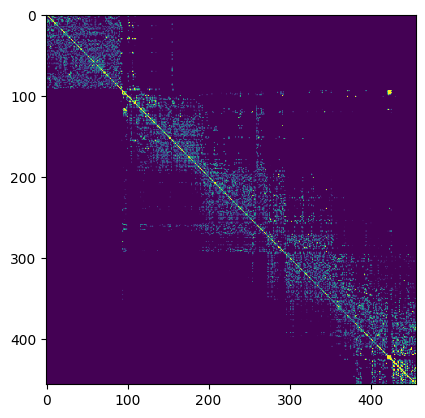

In [9]:
P_key = "statot"
plt.imshow(np.array(adata.obsm["P_%s" % P_key])[x_ord, :][:, x_ord], vmax = np.quantile(adata.obsm["P_%s" % P_key], 0.995))

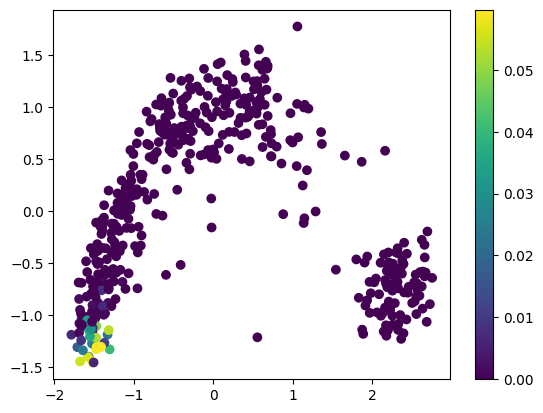

In [10]:
u, v= sp.linalg.eig(np.array(adata.obsm["P_%s" % P_key]).T)
p = np.real(v[:, 0])
p = p/p.sum()
plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = p, vmax = np.quantile(p, 0.995))
plt.colorbar()

In [11]:
np.save(dir + "/X.npy", adata.X)
np.save(dir + "/genes.npy", np.array(adata.var.index, dtype = str))
pd.DataFrame(adata.var.index).to_csv(dir + "/genes.txt")
np.save(dir + "/X_pca.npy", adata.obsm["X_pca"])
np.save(dir + "/X_umap.npy", adata.obsm["X_tsne"])
# save transition matrices
for k in [x for x in adata.obsm.keys() if "P_" in x]:
    print("Writing transition matrix %s..." % k)
    try:
        np.save(dir + "/%s.npy" % k, np.array(adata.obsm[k].todense()))
    except:
        np.save(dir + "/%s.npy" % k, np.array(adata.obsm[k]))

np.save(dir + "/C.npy", adata.obsm["C"])
np.save(dir + "/dpt.npy", adata.obs["t"].to_numpy())
# np.save(dir + "/J.npy", adata.obsm["J"].to_numpy().reshape(-1, adata.X.shape[1], adata.X.shape[1]))

Writing transition matrix P_dpt...
Writing transition matrix P_statot...


In [12]:
# calculate neighbourhood kernel using QOT
import ot
R = ot.smooth.smooth_ot_dual(np.ones(adata.shape[0]), np.ones(adata.shape[0]), adata.obsm["C"], 2.5*adata.obsm["C"].mean())
adata.obsm["R"] = R
np.save(dir + "R.npy", adata.obsm["R"])

In [13]:
J_df = pd.read_csv(dir+"reference_TFTF_network.txt", sep = "\t", header = None)
J_df.columns = pd.Index(["g1", "g2", "x", "y"])
J = pd.DataFrame(np.zeros((adata.shape[1], adata.shape[1])))
J.index = genes.index
J.columns = genes.index
for x in J_df.iloc[:, 0:2].iterrows():
    J.loc[x[1][0], x[1][1]] += 1
np.save(dir + "/J.npy", J.to_numpy())

# ESCAPE gold standard
J_df = pd.read_csv(dir+"EscapeGoldStandard.txt", sep = "\t", header = 0)
J = pd.DataFrame(np.zeros((adata.shape[1], adata.shape[1])))
J.index = genes.index
J.columns = genes.index
for x in J_df.iloc[:, 0:2].iterrows():
    J.loc[x[1][0], x[1][1]] += 1
np.save(dir + "/J_ESCAPE.npy", J.to_numpy())

In [14]:
!julia ../../tools/locaTE.jl/src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --cutoff 0.01 --suffix locate --gpu $dir/X.npy $dir/X_pca.npy $dir/P_statot.npy $dir/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
[ Info: ΔX = 4.5389061514812696e-9, ΔZ = 7.370047772521648e-7, ΔW = 1.0274276419260098e-6
[ Info: tr(X'LX) = 2.57906119528199, 0.5|X-G|^2 = 6.010384253709825, |X|1 = 6599.147591624314

SYSTEM: caught exception of type :IOError while trying to print a failed Task notice; giving up


In [17]:
!JULIA_NUM_THREADS=16 julia ../../tools/locaTE.jl/src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --cutoff 0.01 --suffix locate $dir/X.npy $dir/X_pca.npy $dir/P_statot.npy $dir/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:10:26
[ Info: ΔX = 4.457730183854959e-9, ΔZ = 7.207248609482353e-7, ΔW = 1.0368684165221187e-6
[ Info: tr(X'LX) = 5.39528264198518, 0.5|X-G|^2 = 8.626212403663244, |X|1 = 10686.737285224068
